## Домашняя работа к уроку 5

### Задача оттока: варианты постановки, возможные способы решения

**Домашнее задание**

1. Для нашего пайплайна (``Case1``) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (``True Positive``) удержанного). (подсказка) нужно посчитать ``FP/TP/FN/TN`` для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (Опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (Опционально) Еще раз провести оценку экономической эффективности

**Ссылки**

- http://hyperopt.github.io/hyperopt/
- https://arxiv.org/pdf/1907.03947.pdf
- https://arxiv.org/pdf/1802.02301.pdf
- https://arxiv.org/list/stat.ML/recent
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/compose.html

---

In [1]:
# Загрузка необходимых библиотек

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Загрузка данных

df_churn = pd.read_csv('churn_data.csv')

# Проверка

df_churn.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


---

**1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями:**

In [3]:
# Сплит на trin и test

X_train, X_test, y_train, y_test = train_test_split(df_churn, df_churn['Exited'], random_state = 42)

Категории - OneHot;
Вещественные - без изменений

In [4]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, column):
        self.column = column

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        return X[self.column]


class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        return X[[self.key]]


class OHEEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y = None):
        self.columns = [col for col in pd.get_dummies(X, prefix = self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix = self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [5]:
# Списки признаков

categorical = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [6]:
# Создание трансформера и объединение в список (цикл)

transformer = list()

for categorical_column in categorical:
    
    categorical_transformer = Pipeline([('selector', FeatureSelector(column = categorical_column)),
                                ('ohe', OHEEncoder(key = categorical_column))])
    transformer.append((categorical_column, categorical_transformer))

for continuous_column in continuous:
    continuous_transformer = Pipeline([('selector', NumberSelector(key = continuous_column)),
                                 ('standard', StandardScaler())])
    transformer.append((continuous_column, continuous_transformer))

In [7]:
# Единый пайплайн для признаков для моделирования

feats = FeatureUnion(transformer)

feature_processing = Pipeline([('feats', feats)])

In [8]:
# Модель

pipeline = Pipeline([('features', feats),
                     ('random_forest_classifier',
                      RandomForestClassifier(random_state = 42))])

pipeline.fit(X_train, y_train)
pipeline.predict_proba(X_test)[:, 1]

array([0.02, 0.01, 0.23, ..., 0.07, 0.16, 0.1 ])

In [9]:
# Функция для score

def score(model):

    pipeline = Pipeline([('features', feats), ('model', model)])
    
    pipeline.fit(X_train, y_train)

    preds = pipeline.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    fscore = (2 * precision * recall) / (precision + recall)
    roc_auc = roc_auc_score(y_true = y_test, y_score = preds)
    ix = np.argmax(fscore)

    return [round(i, 3) for i in
            [thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc]]

---

**2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)**

In [12]:
%time

results = pd.DataFrame([
    score(model = RandomForestClassifier(random_state = 42)),
    score(model = GradientBoostingClassifier(random_state = 42)),
    score(model = LogisticRegression(random_state = 42))
], columns = ['Best Threshold', 'F-Score', 'Precision', 'Recall', 'ROC AUC score'])

results['models'] = ['RandomForestClassifier', 'GradientBoosting', 'LogisticRegression']
results = results.set_index('models')

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.81 µs


/var/folders/wf/0ws1q6ks6yv_xwm2_24s254h0000gn/T/ipykernel_11766/405119776.py:12: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


In [13]:
results.sort_values(by = 'Recall', axis = 0, ascending = False)

,Best Threshold,F-Score,Precision,Recall,ROC AUC score
models,,,,,
GradientBoosting,0.272,0.642,0.602,0.686,0.866
RandomForestClassifier,0.360,0.619,0.643,0.598,0.854
LogisticRegression,0.916,NaN,0.000,0.000,0.773


**Вывод:** ``Recall`` подходит больше из-за того, что нужно определить максимум выходящих пользователей. Самая подходящая модель - ``RandomForest``

---

**3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2**

In [14]:
# Pipeline

pipeline = Pipeline([('features', feats),
                     ('random_forest_classifier',
                      RandomForestClassifier(random_state = 42))])

pipeline.fit(X_train, y_train)

y_score = pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_score)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

In [15]:
# Функция для plot matrix

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

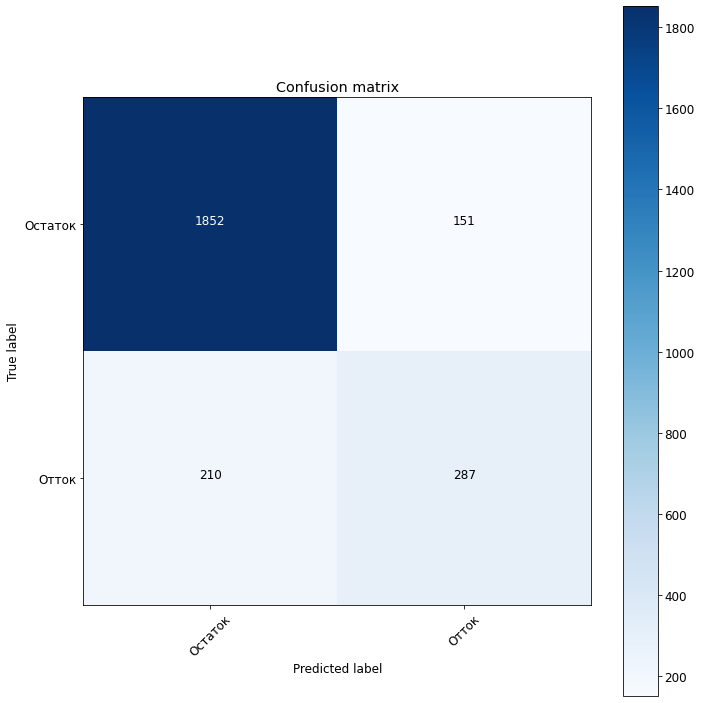

In [16]:
# Проверка результата

font = {'size' : 12}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize = (10, 10))
plot_confusion_matrix(cnf_matrix, classes = ['Остаток', 'Отток'],
                      title = 'Confusion matrix');

In [17]:
# Расчет прибыли

costs = sum(cnf_matrix[:, 1]) * 1
revenue = cnf_matrix[1, 1] * 2

print(f'Возможная прибыть с удержания = {revenue - costs}$')

Возможная прибыть с удержания = 136$
